# **Random Forest ile Enerji Tüketimi ve Menzil Tahmini**


Bu not defteri, gerçek araç verilerini kullanarak elektrikli araçların menzil ve enerji tüketimini tahmin edebilen bir makine öğrenmesi modeli (Random Forest Regresyon) geliştirme sürecini detaylandırmaktadır. Ayrıca, hız, ivme, yol eğimi ve batarya durumu gibi faktörlerin enerji tüketimine anlık etkileri analiz edilmiş ve sonuçlar görselleştirilmiştir.


### **Random Forest Seçilme Sebepleri**

1. **Doğrusal Olmayan İlişkileri Yakalama:**
Enerji tüketimi hız, ivme, yol eğimi ve batarya durumu gibi birçok değişkene bağlıdır. Bu ilişkiler çoğu zaman doğrusal değildir. Random Forest, bu karmaşık ve doğrusal olmayan ilişkileri yakalayabilir.

2. **Aykırı Değerlere Karşı Dayanıklılık:**
Gerçek araç verilerinde sensör hataları veya ani sürüş davranışları gibi aykırı değerler bulunabilir. Random Forest, tek bir ağaç yerine birçok ağacı birleştirdiği için bu tür aykırılıklara karşı daha dayanıklıdır.

3. **Özellik Önemini Belirleme (Feature Importance):**
Model, hangi değişkenlerin enerji tüketimine daha fazla etki ettiğini ölçebilir. Bu sayede hız, eğim, sıcaklık gibi faktörlerin menzil üzerindeki rolü sayısal olarak incelenebilir.

4. **Genel Performans ve Kararlılık:**
Aşırı öğrenmeye (overfitting) karşı güçlüdür ve eğitim–test performansı genellikle dengelidir. Gerçek verilerle yapılan modellemede güvenilir sonuçlar sağlar.

## **1. Kütüphaneler**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import GroupShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance


## **2. Veri Yükleme Ve Ön İncelemeler**

In [ ]:
# Model eğitimi için kullanılacak random state değişkeni
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Seçtiğimiz target
TARGET = "soc_net_per_s_smooth5"

uploaded = files.upload()
df = pd.read_csv("ev_dataset_multi_target.csv")
DATA_PATH = "ev_dataset_multi_target.csv"
df.head()

Saving ev_dataset_multi_target.csv to ev_dataset_multi_target.csv


,CELL_V_AVG,Torque_Measured,MotorTemperature,DC_Link_Voltage,DC_Link_Current,Average_Velocity,Load,Direction,Season,slope,speed_ms,acc_ms2,power_W,cell_voltage_diff,soc_net_per_s,soc_net_per_s_smooth5,soc_net_per_s_smooth10,soc_net_per_s_30s,soc_net_per_s_60s
0,3316.50,12.56,84.68,49.687500,14.17,15,Loaded,CISAR,Summer,0.0,0.044935,0.000000,704.071875,7.54,0.000,0.0028,0.0048,0.0,0.0
1,3313.15,24.26,84.52,49.593125,30.35,15,Loaded,CISAR,Summer,0.0,0.488215,0.443281,1505.151344,7.47,0.008,0.0028,0.0048,0.0,0.0
2,3311.55,22.00,84.47,49.530625,34.48,15,Loaded,CISAR,Summer,0.0,0.968013,0.479798,1707.815950,7.83,0.002,0.0028,0.0048,0.0,0.0
3,3309.89,22.52,84.65,49.482500,41.73,15,Loaded,CISAR,Summer,0.0,1.348039,0.380026,2064.904725,7.84,-0.000,0.0040,0.0048,0.0,0.0
4,3308.00,23.06,84.63,49.441875,47.54,15,Loaded,CISAR,Summer,0.0,1.649832,0.301792,2350.466737,7.53,0.004,0.0032,0.0048,0.0,0.0


In [ ]:
# Veri yükleme ve hızlı EDA
df = pd.read_csv(DATA_PATH)

print("Şekil:", df.shape)
print("Sütunlar:", list(df.columns))
print("\nTip bilgisi:")
display(df.dtypes)


Şekil: (14657, 19)
Sütunlar: ['CELL_V_AVG', 'Torque_Measured', 'MotorTemperature', 'DC_Link_Voltage', 'DC_Link_Current', 'Average_Velocity', 'Load', 'Direction', 'Season', 'slope', 'speed_ms', 'acc_ms2', 'power_W', 'cell_voltage_diff', 'soc_net_per_s', 'soc_net_per_s_smooth5', 'soc_net_per_s_smooth10', 'soc_net_per_s_30s', 'soc_net_per_s_60s']

Tip bilgisi:


,0
CELL_V_AVG,float64
Torque_Measured,float64
MotorTemperature,float64
DC_Link_Voltage,float64
DC_Link_Current,float64
Average_Velocity,int64
Load,object
Direction,object
Season,object
slope,float64


In [ ]:
print("\nEksik değer sayıları (büyükten küçüğe):")
display(df.isna().sum().sort_values(ascending=False))


Eksik değer sayıları (büyükten küçüğe):


,0
CELL_V_AVG,0
Torque_Measured,0
MotorTemperature,0
DC_Link_Voltage,0
DC_Link_Current,0
Average_Velocity,0
Load,0
Direction,0
Season,0
slope,0


-> Daha önce veri temizleme işlemi yaptığımız için verilerimiz eksiksiz.

In [ ]:
display(df.head(10))

,CELL_V_AVG,Torque_Measured,MotorTemperature,DC_Link_Voltage,DC_Link_Current,Average_Velocity,Load,Direction,Season,slope,speed_ms,acc_ms2,power_W,cell_voltage_diff,soc_net_per_s,soc_net_per_s_smooth5,soc_net_per_s_smooth10,soc_net_per_s_30s,soc_net_per_s_60s
0,3316.50,12.56,84.68,49.687500,14.17,15,Loaded,CISAR,Summer,0.000000,0.044935,0.000000,704.071875,7.54,0.000,0.0028,0.0048,0.0,0.0
1,3313.15,24.26,84.52,49.593125,30.35,15,Loaded,CISAR,Summer,0.000000,0.488215,0.443281,1505.151344,7.47,0.008,0.0028,0.0048,0.0,0.0
2,3311.55,22.00,84.47,49.530625,34.48,15,Loaded,CISAR,Summer,0.000000,0.968013,0.479798,1707.815950,7.83,0.002,0.0028,0.0048,0.0,0.0
3,3309.89,22.52,84.65,49.482500,41.73,15,Loaded,CISAR,Summer,0.000000,1.348039,0.380026,2064.904725,7.84,-0.000,0.0040,0.0048,0.0,0.0
4,3308.00,23.06,84.63,49.441875,47.54,15,Loaded,CISAR,Summer,0.000000,1.649832,0.301792,2350.466737,7.53,0.004,0.0032,0.0048,0.0,0.0
5,3304.21,29.42,84.70,49.276250,70.61,15,Loaded,CISAR,Summer,8.847910,1.957071,0.307239,3479.396012,8.38,0.006,0.0040,0.0048,0.0,0.0
6,3298.47,33.58,84.76,49.096875,93.46,15,Loaded,CISAR,Summer,-242.179048,2.487745,0.530674,4588.593937,8.64,0.004,0.0060,0.0057,0.0,0.0
7,3294.14,33.22,84.72,49.003125,104.97,15,Loaded,CISAR,Summer,0.000000,3.013468,0.525723,5143.858031,11.22,0.006,0.0068,0.0058,0.0,0.0
8,3292.91,30.64,84.76,48.968750,104.54,15,Loaded,CISAR,Summer,0.000000,3.434343,0.420875,5119.193125,9.23,0.010,0.0074,0.0061,0.0,0.0
9,3291.39,30.00,84.70,48.928125,109.32,15,Loaded,CISAR,Summer,34.129180,3.786765,0.352421,5348.822625,13.79,0.008,0.0084,0.0070,0.0,0.0


## **3. Hedef değişken kontrolü ve dağılım**

count    14657.000000
mean         0.003168
std          0.004742
min         -0.008000
25%          0.000000
50%          0.002000
75%          0.005600
max          0.028000
Name: soc_net_per_s_smooth5, dtype: float64


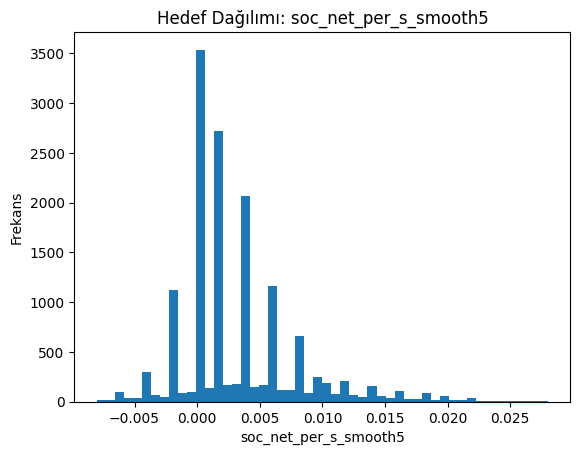

In [ ]:
assert TARGET in df.columns, f"Hedef '{TARGET}' bulunamadı!"
y = pd.to_numeric(df[TARGET], errors="coerce")

print(y.describe())

plt.figure()
plt.hist(y.dropna(), bins=50)
plt.title("Hedef Dağılımı: soc_net_per_s_smooth5")
plt.xlabel("soc_net_per_s_smooth5")
plt.ylabel("Frekans")
plt.show()

## **4. Kategorik Değişkenler**

Modelin öğrenme sürecinde yalnızca sayısal veriler kullanılabilir. Bu nedenle, veri setinde bulunan kategorik değişkenlerin sayısal forma dönüştürülmesi gerekir. Bu işlem için One-Hot Encoding yöntemi uygulanmıştır.

In [ ]:
# Kategorik kolonlar
categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

print("Kategorik kolonlar:", categorical_cols)


Kategorik kolonlar: ['Load', 'Direction', 'Season']


In [ ]:
# OneHotEncoder nesnesi
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False,drop="first")

# Sadece kategorik kolonları encode edildi
X_cat_encoded = encoder.fit_transform(df[categorical_cols])

# Yeni kolon isimlerini alındı
encoded_col_names = encoder.get_feature_names_out(categorical_cols)

df_encoded = pd.DataFrame(X_cat_encoded, columns=encoded_col_names, index=df.index)

# Eski kategorik kolonları çıkarıp yerine encode edilmiş olanları koyuldu
df_numeric = df.drop(columns=categorical_cols).join(df_encoded)

print("Yeni şekil:", df_numeric.shape)
df_numeric.head()



Yeni şekil: (14657, 19)


,CELL_V_AVG,Torque_Measured,MotorTemperature,DC_Link_Voltage,DC_Link_Current,Average_Velocity,slope,speed_ms,acc_ms2,power_W,cell_voltage_diff,soc_net_per_s,soc_net_per_s_smooth5,soc_net_per_s_smooth10,soc_net_per_s_30s,soc_net_per_s_60s,Load_Unloaded,Direction_MMF,Season_Winter
0,3316.50,12.56,84.68,49.687500,14.17,15,0.0,0.044935,0.000000,704.071875,7.54,0.000,0.0028,0.0048,0.0,0.0,0.0,0.0,0.0
1,3313.15,24.26,84.52,49.593125,30.35,15,0.0,0.488215,0.443281,1505.151344,7.47,0.008,0.0028,0.0048,0.0,0.0,0.0,0.0,0.0
2,3311.55,22.00,84.47,49.530625,34.48,15,0.0,0.968013,0.479798,1707.815950,7.83,0.002,0.0028,0.0048,0.0,0.0,0.0,0.0,0.0
3,3309.89,22.52,84.65,49.482500,41.73,15,0.0,1.348039,0.380026,2064.904725,7.84,-0.000,0.0040,0.0048,0.0,0.0,0.0,0.0,0.0
4,3308.00,23.06,84.63,49.441875,47.54,15,0.0,1.649832,0.301792,2350.466737,7.53,0.004,0.0032,0.0048,0.0,0.0,0.0,0.0,0.0


## **5. Random Forest Modeli Eğitimi**

## **5.1 Target = soc_net_per_s_smooth5**

### **5.1.1 Eğitim/Test Ayrımı**

Makine öğrenmesi modellerinin performansını objektif bir şekilde değerlendirebilmek için veri seti eğitim (train) ve test olmak üzere ikiye ayrılmıştır. Eğitim seti, modelin parametrelerini öğrenmesi için kullanılırken; test seti, daha önce hiç görmediği veriler üzerinde modelin doğruluğunu ölçmek için ayrılmıştır.

X → bağımsız değişkenler (özellikler, yani girişler).

y → bağımlı değişken (hedef, yani çıkış soc_net_per_s).

test_size=0.20 → verinin %20’si test setine, %80’i eğitim setine ayrılır.

random_state=RANDOM_STATE → rastgele bölmeyi tekrarlanabilir yapmak için. Böylece aynı kodu her çalıştırdığında aynı şekilde bölünür.


In [ ]:
# Üstte sayısal olarak belirlediğimiz değişkenleri X'e atıyoruz.
drop_targets = {
    "soc_net_per_s",
    "soc_net_per_s_smooth5",
    "soc_net_per_s_smooth10",
    "soc_net_per_s_30s",
    "soc_net_per_s_60s"
}
X = df_numeric.drop(columns=drop_targets ,errors ="ignore" )

# Hedef değişkeni y'ye atıyoruz.
y = df_numeric['soc_net_per_s_smooth5']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape


((11725, 14), (2932, 14))

### **5.1.2 Model Eğitimi**

In [ ]:
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf.fit(X_train, y_train)
print("Model eğitimi tamamlandı.")

Model eğitimi tamamlandı.


**Baseline Eğitimi ve İlk Metrikler**

Elde edilen sonuçlar, modelin başlangıçta veriden ne kadar anlamlı bilgi çıkarabildiğini göstermektedir. İlk değerlendirmeler için aşağıdaki metrikler hesaplanmıştır:
* R² (Determinasyon Katsayısı): Modelin bağımlı değişkeni (enerji tüketimi) açıklama oranını gösterir.

* MAE (Ortalama Mutlak Hata): Tahmin edilen değerler ile gerçek değerler arasındaki mutlak farkların ortalamasıdır.

* RMSE (Kök Ortalama Kare Hatası): Büyük hatalara daha fazla ceza vererek modelin genel tahmin performansını ölçer.



In [ ]:

y_pred = rf.predict(X_test)

r2  = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Baseline — R² : {r2:.4f}")
print(f"Baseline — MAE: {mae:.6f}")
print(f"Baseline — RMSE: {rmse:.6f}")

Baseline — R² : 0.8767
Baseline — MAE: 0.001176
Baseline — RMSE: 0.001615


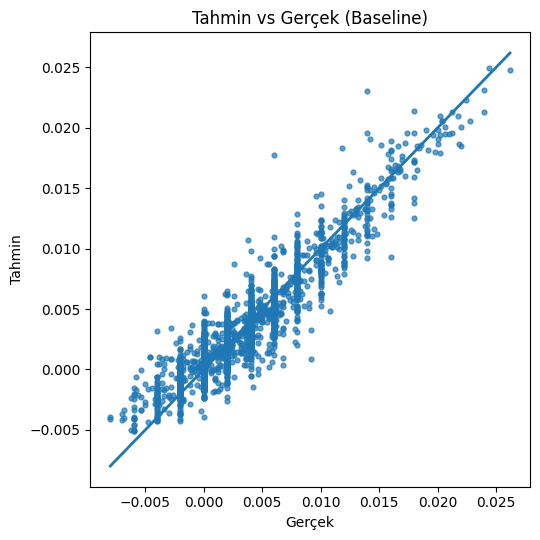

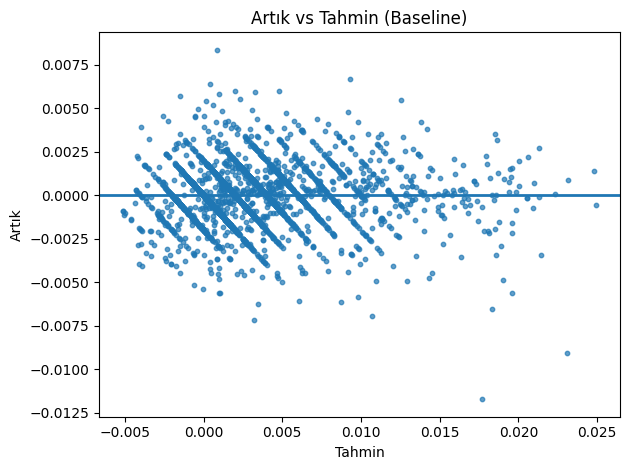

In [ ]:
# Tahmin vs Gerçek
plt.figure(figsize=(5.5,5.5))
plt.scatter(y_test, y_pred, s=12, alpha=0.7)
mn, mx = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], linewidth=2)
plt.title("Tahmin vs Gerçek (Baseline)")
plt.xlabel("Gerçek")
plt.ylabel("Tahmin")
plt.tight_layout()
plt.show()

# X ekseni → gerçek değerler (y_test)
# Y ekseni → modelin tahminleri (y_pred)
# Ortadaki çapraz çizgi (45°’lik) → ideal hat (tahmin = gerçek)
# Eğer noktalar bu çizgiye yakınsa → modelin tahminleri gerçeğe yakın demektir.


# Artıklar (y_true - y_pred)
residuals = y_test - y_pred

plt.figure()
plt.scatter(y_pred, residuals, s=10, alpha=0.7)
plt.axhline(0, linewidth=2)
plt.title("Artık vs Tahmin (Baseline)")
plt.xlabel("Tahmin")
plt.ylabel("Artık")
plt.tight_layout()
plt.show()

# Artık (residual) = gerçek değer − tahmin
# X ekseni → modelin tahminleri
# Y ekseni → artıklar (hatalar)
# Ortadaki yatay çizgi (0) → ideal durum (hiç hata yok).

### **5.1.3. RandomizedSearchCV ile Hiperparametre Arama**

Baseline modelden sonra, modelin performansını artırmak için **hiperparametre optimizasyonu** yapılmıştır. Random Forest algoritması; ağaç sayısı, maksimum derinlik, minimum yaprak sayısı gibi birçok parametreye bağlı olarak farklı sonuçlar verebilir. Bu parametrelerin en uygun kombinasyonunu bulmak için **RandomizedSearchCV** yöntemi tercih edilmiştir.


RandomizedSearchCV’nin kullanılma sebepleri şunlardır:

* Tüm olasılıkları denemek yerine, belirli bir sayıda rastgele kombinasyon seçerek daha hızlı sonuç verir.

* Çapraz doğrulama (cross-validation) ile her parametre kombinasyonunun genellenebilirliği test edilir.

Arama sırasında aşağıdaki hiperparametre aralıkları belirlenmiştir:

* ***n_estimators*** : Orman içindeki ağaç sayısı

* ***max_depth*** : Ağaçların maksimum derinliği

* ***min_samples_split*** : Dallanma için gereken minimum örnek sayısı

* ***min_samples_leaf*** : Bir yapraktaki minimum örnek sayısı

* ***max_features*** : Dallanmalarda kullanılacak özellik sayısı

Elde edilen en iyi parametre kombinasyonu, baseline modeline göre daha yüksek doğruluk sağlamış ve hata oranlarını düşürmüştür. Bu sayede enerji tüketimi tahmininde daha güvenilir bir model oluşturulmuştur.

In [ ]:
param_dist = {
    "n_estimators": [300, 500, 700, 900, 1100],
    "max_depth": [None, 10, 20, 30, 40, 60],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", 1.0],
    "bootstrap": [True]
}

In [ ]:
search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=25,
    cv=5,
    scoring="neg_mean_absolute_error",
    random_state=RANDOM_STATE,
    verbose=1,
    n_jobs=-1
)

search.fit(X_train, y_train)

print("En iyi parametreler:", search.best_params_)
print("CV (best) MAE:", -search.best_score_)
best_rf = search.best_estimator_

Fitting 5 folds for each of 25 candidates, totalling 125 fits
En iyi parametreler: {'n_estimators': 1100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 1.0, 'max_depth': None, 'bootstrap': True}
CV (best) MAE: 0.0011583835097973938


In [ ]:
rf_best = RandomForestRegressor(
    n_estimators=1100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    max_features=1,
    bootstrap=True,
    n_jobs=-1
)

rf_best.fit(X_train, y_train)

y_test_pred = rf_best.predict(X_test)

r2  = r2_score(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Best RF — R² : {r2:.4f}")
print(f"Best RF — MAE: {mae:.6f}")
print(f"Best RF — RMSE: {rmse:.6f}")

Best RF — R² : 0.8825
Best RF — MAE: 0.001149
Best RF — RMSE: 0.001576


,0
power_W,0.156922
DC_Link_Current,0.155814
Torque_Measured,0.115979
DC_Link_Voltage,0.114249
CELL_V_AVG,0.105568
cell_voltage_diff,0.093288
slope,0.073872
acc_ms2,0.058151
speed_ms,0.047310
MotorTemperature,0.034586


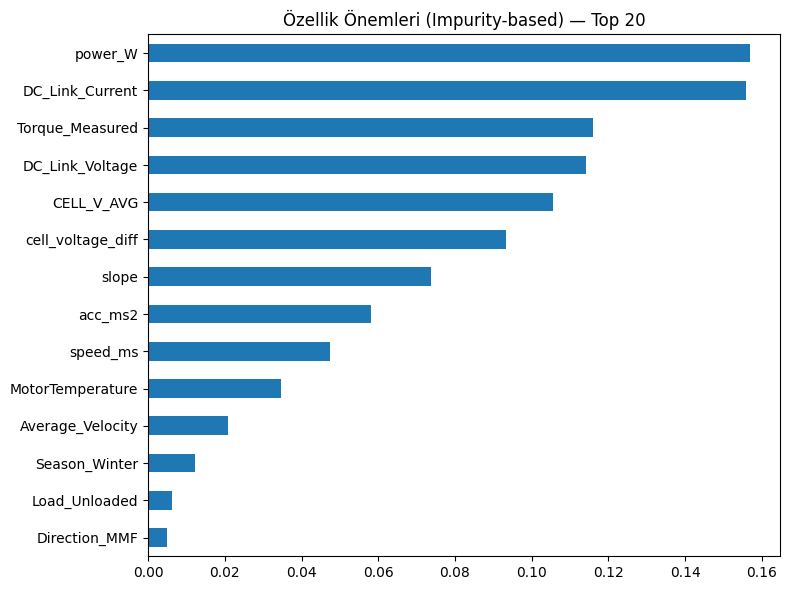

In [ ]:
importances = (
    pd.Series(rf_best.feature_importances_, index=X_train.columns)
    .sort_values(ascending=False)
)

display(importances.head(20))

plt.figure(figsize=(8, 6))
importances.head(20).iloc[::-1].plot.barh()
plt.title("Özellik Önemleri (Impurity-based) — Top 20")
plt.tight_layout()
plt.show()

In [ ]:
best_model = rf_best

Best — R²: 0.8825 | MAE: 0.001149 | RMSE: 0.001615


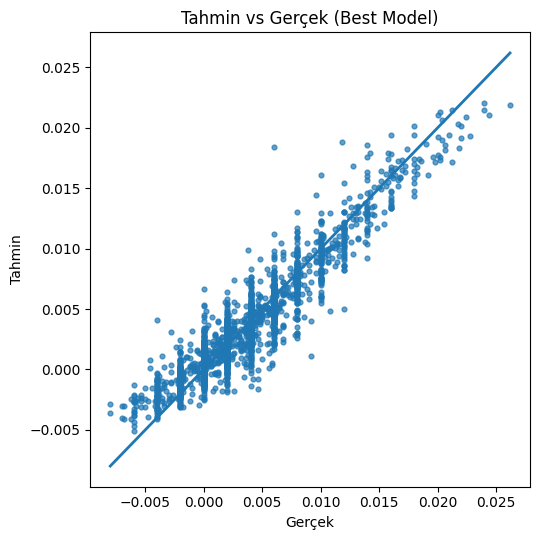

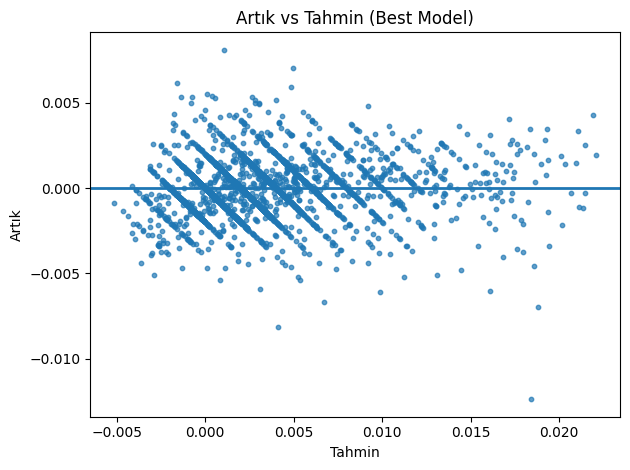

In [ ]:
y_pred_best = best_model.predict(X_test)

r2  = r2_score(y_test, y_pred_best)
mae = mean_absolute_error(y_test, y_pred_best)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Best — R²: {r2:.4f} | MAE: {mae:.6f} | RMSE: {rmse:.6f}")

# Tahmin vs Gerçek
plt.figure(figsize=(5.5,5.5))
plt.scatter(y_test, y_pred_best, s=12, alpha=0.7)
mn, mx = min(y_test.min(), y_pred_best.min()), max(y_test.max(), y_pred_best.max())
plt.plot([mn, mx], [mn, mx], linewidth=2)
plt.title("Tahmin vs Gerçek (Best Model)")
plt.xlabel("Gerçek")
plt.ylabel("Tahmin")
plt.tight_layout()
plt.show()

# Artıklar
residuals = y_test - y_pred_best

plt.figure()
plt.scatter(y_pred_best, residuals, s=10, alpha=0.7)
plt.axhline(0, linewidth=2)
plt.title("Artık vs Tahmin (Best Model)")
plt.xlabel("Tahmin")
plt.ylabel("Artık")
plt.tight_layout()
plt.show()

## **5.2 Target = soc_net_per_s_smooth10**

### **5.2.1 Eğitim/Test Ayrımı**

In [ ]:
# Üstte sayısal olarak belirlediğimiz değişkenleri X'e atıyoruz.
drop_targets = {
    "soc_net_per_s",
    "soc_net_per_s_smooth5",
    "soc_net_per_s_smooth10",
    "soc_net_per_s_30s",
    "soc_net_per_s_60s"
}
X = df_numeric.drop(columns=drop_targets ,errors ="ignore" )

# Hedef değişkeni y'ye atıyoruz.
y = df_numeric['soc_net_per_s_smooth10']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape

((11725, 14), (2932, 14))

### **5.2.2 Model Eğitimi**

In [ ]:
rf = RandomForestRegressor(
    n_estimators=1100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    max_features=1,
    bootstrap=True,
    n_jobs=-1
)

rf.fit(X_train, y_train)
print("Model eğitimi tamamlandı.")

Model eğitimi tamamlandı.


In [ ]:
y_pred = rf.predict(X_test)

r2  = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Baseline — R² : {r2:.4f}")
print(f"Baseline — MAE: {mae:.6f}")
print(f"Baseline — RMSE: {rmse:.6f}")

Baseline — R² : 0.8352
Baseline — MAE: 0.001106
Baseline — RMSE: 0.001626


## **5.3 Target = soc_net_per_s_30s**

### **5.3.1 Eğitim/Test Ayrımı**

In [ ]:
# Üstte sayısal olarak belirlediğimiz değişkenleri X'e atıyoruz.
drop_targets = {
    "soc_net_per_s",
    "soc_net_per_s_smooth5",
    "soc_net_per_s_smooth10",
    "soc_net_per_s_30s",
    "soc_net_per_s_60s"
}
X = df_numeric.drop(columns=drop_targets ,errors ="ignore" )

# Hedef değişkeni y'ye atıyoruz.
y = df_numeric['soc_net_per_s_30s']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape

((11725, 14), (2932, 14))

### **5.3.2 Model Eğitimi**

In [ ]:
rf = RandomForestRegressor(
    n_estimators=1100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    max_features=1,
    bootstrap=True,
    n_jobs=-1
)

rf.fit(X_train, y_train)
print("Model eğitimi tamamlandı.")

Model eğitimi tamamlandı.


In [ ]:
y_pred = rf.predict(X_test)

r2  = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Baseline — R² : {r2:.4f}")
print(f"Baseline — MAE: {mae:.6f}")
print(f"Baseline — RMSE: {rmse:.6f}")

Baseline — R² : 0.7908
Baseline — MAE: 0.001049
Baseline — RMSE: 0.001527


## **5.4 Target = soc_net_per_s_60s**

### **5.4.1 Eğitim/Test Ayrımı**

In [ ]:
# Üstte sayısal olarak belirlediğimiz değişkenleri X'e atıyoruz.
drop_targets = {
    "soc_net_per_s",
    "soc_net_per_s_smooth5",
    "soc_net_per_s_smooth10",
    "soc_net_per_s_30s",
    "soc_net_per_s_60s"
}
X = df_numeric.drop(columns=drop_targets ,errors ="ignore" )

# Hedef değişkeni y'ye atıyoruz.
y = df_numeric['soc_net_per_s_60s']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape

((11725, 14), (2932, 14))

### **5.4.2 Model Eğitimi**

In [ ]:
rf = RandomForestRegressor(
    n_estimators=1100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    max_features=1,
    bootstrap=True,
    n_jobs=-1
)

rf.fit(X_train, y_train)
print("Model eğitimi tamamlandı.")

Model eğitimi tamamlandı.


In [ ]:
y_pred = rf.predict(X_test)

r2  = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Baseline — R² : {r2:.4f}")
print(f"Baseline — MAE: {mae:.6f}")
print(f"Baseline — RMSE: {rmse:.6f}")

Baseline — R² : 0.7866
Baseline — MAE: 0.000969
Baseline — RMSE: 0.001389


# **Menzil Tahmini (Range)**

Anlık menzil (km) ≈ usable_kWh / (cons_kWh_per_km)

cons_kWh_per_km = energy_consumption / 100

⇒ range_km ≈ usable_kWh * 100 / energy_consumption

In [ ]:
usable_kwh_est = estimate_usable_kwh_robust(
    df,
    soc_col="soc_net_per_s_smooth5",
    volt_col="DC_Link_Voltage",
    curr_col="DC_Link_Current",
    dt=1.0,
    min_total_soc_drop_pct=0.5
)
print("Tahmini Kullanılabilir Batarya Kapasitesi (kWh):", usable_kwh_est)


Tahmini Kullanılabilir Batarya Kapasitesi (kWh): 62.76127786357383


In [ ]:
mask_drive = (df["speed_ms"] > 2.0) & (df["power_W"] > 0)
df["cons_kwh_per_100km"] = np.where(
    mask_drive,
    0.027778 * df["power_W"] / df["speed_ms"],
    np.nan
)

# 1) Dinamik sınırlar (aşırı uçları kırpıldı): P5–P95
p5  = np.nanpercentile(df["cons_kwh_per_100km"], 5)
p95 = np.nanpercentile(df["cons_kwh_per_100km"], 95)

# Araç/rota mantığıyla çok uç güvenlik sınırları: 6–60
low_bound  = max(6.0, p5)
high_bound = min(60.0, p95)

# 2) Rolling median + dinamik klips
df["cons_kwh_per_100km_filt"] = (
    df["cons_kwh_per_100km"]
      .rolling(window=15, min_periods=1).median()
      .clip(lower=low_bound, upper=high_bound)
)

df["cons_kwh_per_100km_filt"] = (
    df["cons_kwh_per_100km_filt"]
      .ffill(limit=5)
      .bfill(limit=5)
)

# 3) Kapasite (kWh) —robust fonksiyonuyla
usable_kwh_est = estimate_usable_kwh_robust(
    df,
    soc_col="soc_net_per_s_smooth5",
    volt_col="DC_Link_Voltage",
    curr_col="DC_Link_Current",
    dt=1.0,
    min_total_soc_drop_pct=0.5
)

# 4) Menzil (km) — NaN olmayan yerlerde hesaplama
def predict_range_km(cons_series, usable_kwh, eps=1e-3):
    cons = cons_series.values
    cons = np.where(np.isnan(cons), np.nan, np.maximum(cons, eps))
    return usable_kwh * 100.0 / cons

range_km_series = predict_range_km(df["cons_kwh_per_100km_filt"], usable_kwh_est)

range_km_series = np.clip(range_km_series, 0, 700)

print("Menzil (ilk 20):", range_km_series[1:20])

Menzil (ilk 20): [142.29385697 142.29385697 142.29385697 142.29385697 142.29385697
 142.29385697 142.29385697 142.29385697 142.29385697 151.57689711
 155.6538334  159.95614479 162.4320718  164.98585259 178.50443664
 194.4361112  222.34067331 259.59679182 272.50082578]


# **Faktörlerin (hız, ivme, eğim, batarya sıcaklığı/durumu) anlık tüketimi nasıl etkilediğine dair analiz/görselleştirmeler**

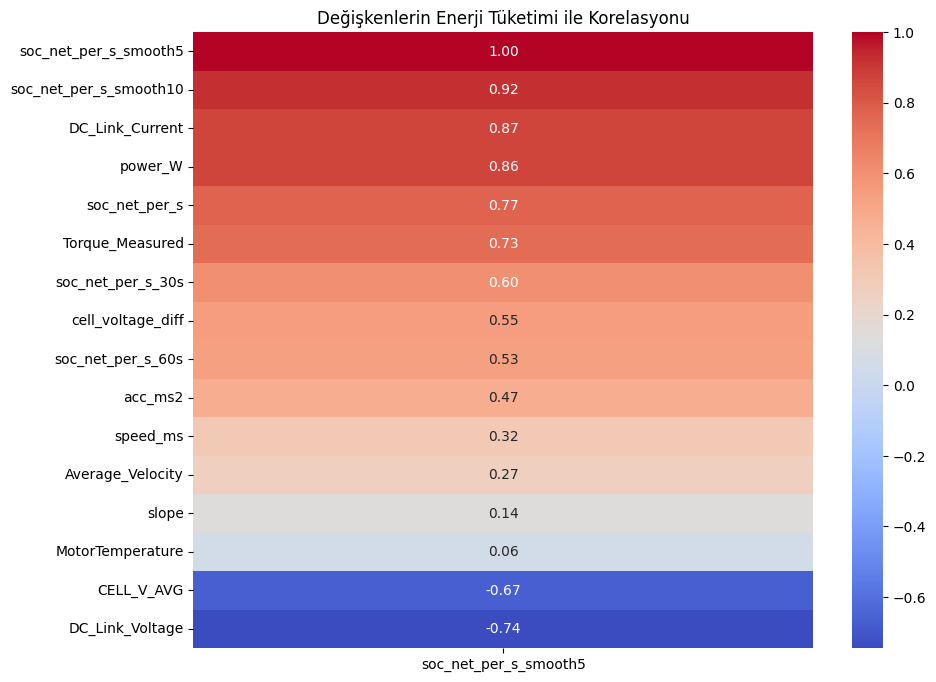

In [ ]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr[['soc_net_per_s_smooth5']].sort_values(by='soc_net_per_s_smooth5', ascending=False),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Değişkenlerin Enerji Tüketimi ile Korelasyonu")
plt.show()

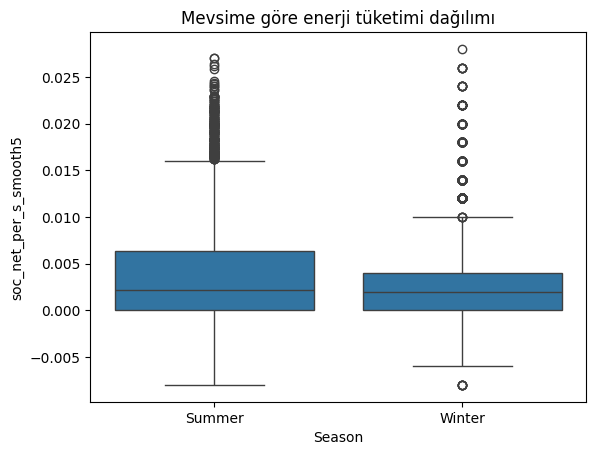

In [ ]:
sns.boxplot(x="Season", y="soc_net_per_s_smooth5", data=df)
plt.title("Mevsime göre enerji tüketimi dağılımı")
plt.show()

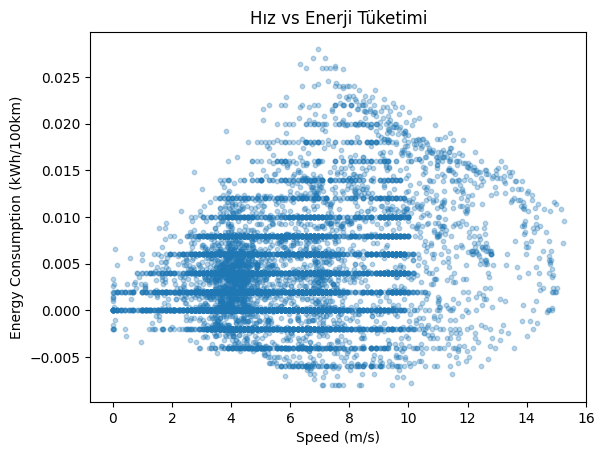

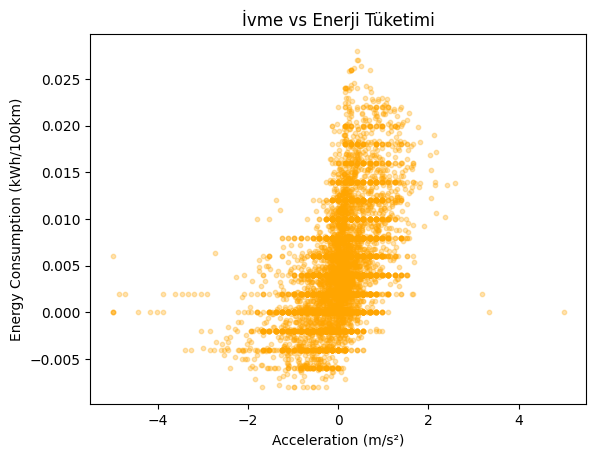

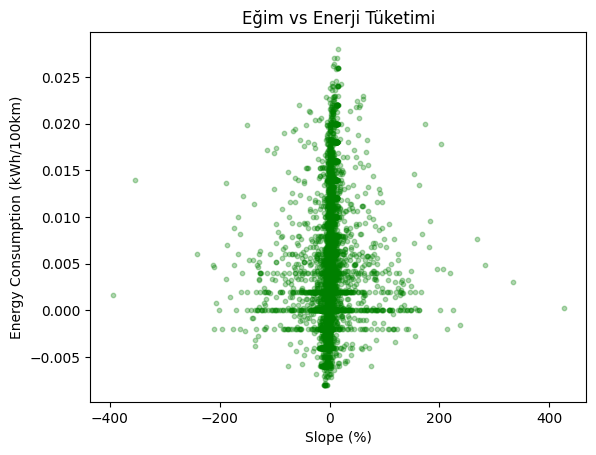

In [ ]:
# Hız ve Tüketim
plt.scatter(df["speed_ms"], df["soc_net_per_s_smooth5"], alpha=0.3, s=10)
plt.xlabel("Speed (m/s)")
plt.ylabel("Energy Consumption (kWh/100km)")
plt.title("Hız vs Enerji Tüketimi")
plt.show()

# İvme ve Tüketim
plt.scatter(df["acc_ms2"], df["soc_net_per_s_smooth5"], alpha=0.3, s=10, color="orange")
plt.xlabel("Acceleration (m/s²)")
plt.ylabel("Energy Consumption (kWh/100km)")
plt.title("İvme vs Enerji Tüketimi")
plt.show()

# Eğim ve Tüketim
plt.scatter(df["slope"], df["soc_net_per_s_smooth5"], alpha=0.3, s=10, color="green")
plt.xlabel("Slope (%)")
plt.ylabel("Energy Consumption (kWh/100km)")
plt.title("Eğim vs Enerji Tüketimi")
plt.show()

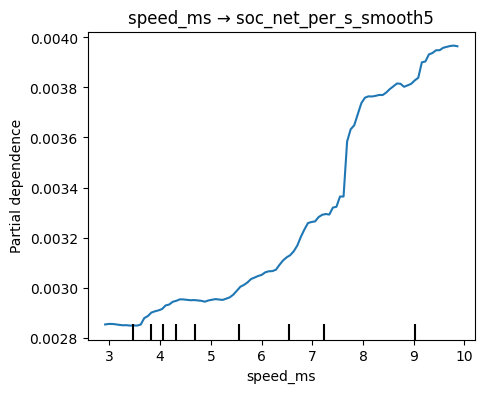

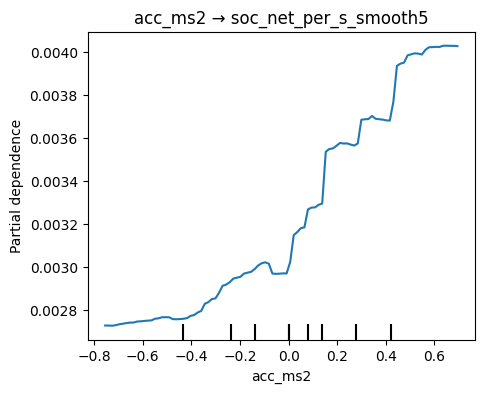

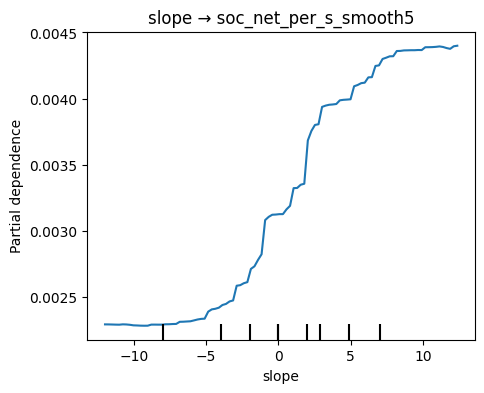

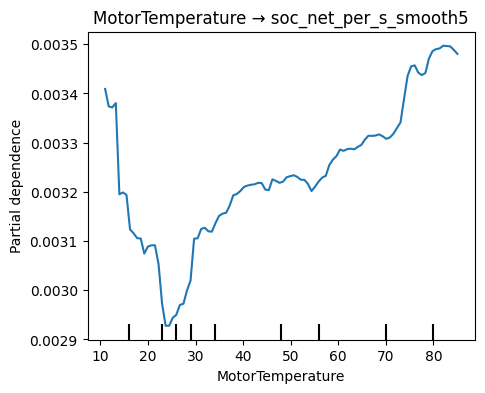

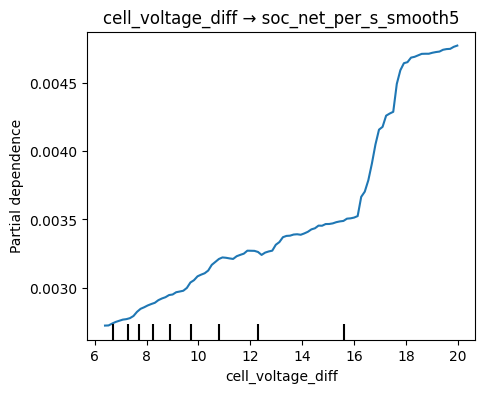

In [ ]:
features = [f for f in ["speed_ms","acc_ms2","slope","MotorTemperature","cell_voltage_diff"] if f in X_train.columns]
for feat in features:
    fig, ax = plt.subplots(figsize=(5,4))
    PartialDependenceDisplay.from_estimator(rf_best, X_train, [feat], ax=ax)
    plt.title(f"{feat} → soc_net_per_s_smooth5")
    plt.show()